In [82]:
import numpy as np
import torch
from botorch.acquisition import ExpectedImprovement, AnalyticAcquisitionFunction, FixedFeatureAcquisitionFunction
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.optim import optimize_acqf
from botorch.test_functions import Levy
from gpytorch.mlls import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt

In [99]:
from botorch.test_functions.synthetic import SyntheticTestFunction
from torch import Tensor
from typing import Optional, List, Tuple

import math


class CustomRadialFunction(SyntheticTestFunction):
    """
    A 2D custom function with a clear single minimum and maximum, and most values in between.
    Global minimum at the origin and a global maximum near (3,3).
    """

    def __init__(self, noise_std: Optional[float] = None, negate: bool = False) -> None:
        """
        Args:
            noise_std: Standard deviation of the observation noise.
            negate: If True, negate the function.
        """
        self.dim = 2  # The function is two-dimensional
        self._bounds = [(-4, 8), (-4, 8)]
        self._optimal_value = None  # Optimal value is context-dependent
        self._optimizers = None  # Optimal locations are context-dependent
        super().__init__(noise_std=noise_std, negate=negate, bounds=self._bounds)

    def evaluate_true(self, X: Tensor) -> Tensor:
        """
        Evaluate the function on a batch of inputs.
        Args:
            X: A tensor of inputs.
        Returns:
            A tensor of function values at the inputs.
        """
        x, y = X[..., 0], X[..., 1]
        return -torch.exp(-(x**2 + y**2) / 10) + 0.5 * torch.exp(-((x-3)**2 + (y-3)**2) / 10)


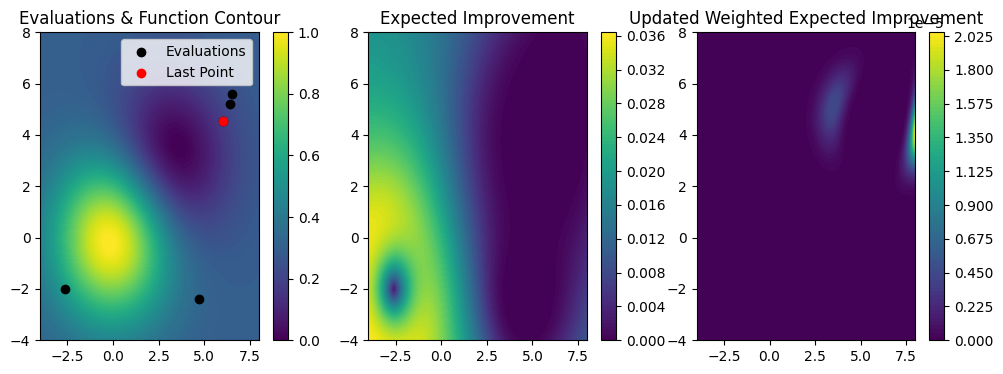

In [122]:

class ExpectedImprovementWithGaussianWeight(AnalyticAcquisitionFunction):
    """
    Expected Improvement (EI) acquisition function multiplied by a Gaussian centered around the last evaluated point,
    adjusted for normalized input space.
    """
    def __init__(self, model, best_f, last_point, std_dev):
        super().__init__(model=model)
        self.model = model
        self.ei = ExpectedImprovement(model=model, best_f=best_f)
        self.last_point = last_point
        self.std_dev = std_dev

    def forward(self, X):
        # Calculate EI values
        ei_vals = self.ei(X)

        # Transform
        X_trans = self.model.input_transform(X)
        lp_trans = self.model.input_transform(self.last_point)

        # Calculate distances from the last evaluated point in the normalized space
        dists = torch.norm(X_trans.squeeze() - lp_trans, dim=1)

        # Calculate Gaussian weights based on the distances
        gaussian_weights = torch.exp(-0.5 * ((dists / self.std_dev) ** 2))

        # Multiply EI by Gaussian weights
        weighted_ei = ei_vals * gaussian_weights
        return weighted_ei

# Define the test function and bounds
obj = CustomRadialFunction(negate=True)

# Generate some initial data
train_x = obj.bounds[0] + (obj.bounds[1] - obj.bounds[0]) * torch.rand(5, 2)
train_obj = obj(train_x).unsqueeze(-1)

# Fit a GP model
model = SingleTaskGP(train_x, train_obj,
                    input_transform=Normalize(d=train_x.shape[-1]),
                    outcome_transform=Standardize(m=1) )
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

# Define a grid for visualization
x = np.linspace(obj.bounds[0][0],obj.bounds[1][0], 100)
y = np.linspace(obj.bounds[0][1],obj.bounds[1][1], 100)
X, Y = np.meshgrid(x, y)
grid = torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype=torch.float)

# Compute EI on the grid
ei = ExpectedImprovement(model=model, best_f=train_obj.max())
ei_vals = ei(grid.unsqueeze(-2)).detach().numpy().reshape(X.shape)

# Assuming the rest of the setup is correct and using the last evaluated point from the provided setup
# Update to use the adjusted standard deviation in a normalized space
last_point = train_x[-1].unsqueeze(0)
weighted_ei = ExpectedImprovementWithGaussianWeight(model, train_obj.max(), last_point, std_dev=0.1)

# We will recompute the weighted EI values for plotting using the updated standard deviation
weighted_ei_vals_updated = weighted_ei(grid.unsqueeze(-2)).detach().numpy().reshape(X.shape)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

# Plotting the Branin function contour in the first subplot alongside scatter points
plt.subplot(1, 3, 1)
contour_levels = np.linspace(obj(grid).min(), obj(grid).max(), 100)
plt.contourf(X, Y, obj(grid).reshape(X.shape), levels=contour_levels, cmap='viridis', alpha=1)
plt.scatter(train_x[:, 0], train_x[:, 1], color='k', label='Evaluations')
plt.scatter(train_x[-1, 0], train_x[-1, 1], color='r', label='Last Point')
plt.colorbar()
plt.legend()
plt.title('Evaluations & Function Contour')

# Plot EI
plt.subplot(1, 3, 2)
plt.contourf(X, Y, ei_vals, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Expected Improvement')

# Plotting the updated weighted EI with the adjusted standard deviation
plt.subplot(1, 3, 3)
plt.contourf(X, Y, weighted_ei_vals_updated, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Updated Weighted Expected Improvement')

plt.show()


In [206]:
def plot_seed(seed, title=None):
    torch.manual_seed(seed)

    # Initialize the GP model with some random data
    initial_data_size = 4
    switches = 6
    cost = 3
    columns = torch.tensor([0])
    std_dev = 1

    train_x = obj.bounds[0] + (obj.bounds[1] - obj.bounds[0]) * torch.rand(initial_data_size, 2)
    train_xff = train_x.clone().detach()   # copy initial points
    train_obj = obj(train_x).unsqueeze(-1)

    for iteration in range(switches):
        # Update the model with the current training data
        model = SingleTaskGP(train_x, train_obj, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)

        # Compute the next point to evaluate
        last_point = train_x[-1].unsqueeze(0)  # Last evaluated point
        acq_func = ExpectedImprovementWithGaussianWeight(model, train_obj.max(), last_point, std_dev=std_dev)
        # acq_func = ExpectedImprovement(model, train_obj.max())
        new_x, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=obj.bounds,
            q=1,
            num_restarts=5,
            raw_samples=2048,
        )

        # Evaluate the new point and update training data
        new_obj = obj(new_x).unsqueeze(-1)
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])

    train_objff = obj(train_xff).unsqueeze(-1)
    budget = switches * cost

    while budget > 0:
        # Update the model with the current training data
        model = SingleTaskGP(train_xff, train_objff, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)

        # Compute the next point to evaluate
        last_point = train_xff[-1].unsqueeze(0)  # Last evaluated point
        acq_func = ExpectedImprovementWithGaussianWeight(model, train_objff.max(), last_point, std_dev=std_dev)
        # acq_func = ExpectedImprovement(model, train_objff.max())

        # get random boolean with probability pff to be True
        if torch.rand(1) < 1/2:
            ff_acq = FixedFeatureAcquisitionFunction(
                acq_function=acq_func,
                d=obj.dim,
                columns=columns,    # indices of fixed features
                values=train_xff[-1, columns],
            )

            new_xuc, _ = optimize_acqf(   # returns a 2D tensor of shape (q, d)
                acq_function=ff_acq,
                bounds=obj.bounds[:, ~torch.isin(torch.arange(obj.dim), 0)],    # remove bounds of fixed features
                q=1,
                num_restarts=5,
                raw_samples=2048,
            )

            # Construct full input tensor
            new_x = ff_acq._construct_X_full(new_xuc)
            budget -= 1
        else:
            new_x, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=obj.bounds,
                q=1,
                num_restarts=5,
                raw_samples=2048,
            )
            budget -= cost

        # Evaluate the new point and update training data
        new_obj = obj(new_x).unsqueeze(-1)
        train_xff = torch.cat([train_xff, new_x])
        train_objff = torch.cat([train_objff, new_obj])


    # Plot the function, evaluations, and arrows indicating the evaluation sequence
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))

    X, Y = np.meshgrid(np.linspace(obj.bounds[0][0],obj.bounds[1][0], 100),
                        np.linspace(obj.bounds[0][1],obj.bounds[1][1], 100))
    Z = obj(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T)).reshape(100, 100).numpy()

    # Create the contour fill and capture its output for the colorbar
    contour = ax.contourf(X, Y, Z, levels=50, alpha=0.5, cmap='viridis')

    # Create the colorbar based on the contour
    fig.colorbar(contour, ax=ax)

    # Initial evaluations in grey
    ax.scatter(train_x[:initial_data_size, 0], train_x[:initial_data_size, 1], color='grey', label='Initial points')

    ax.scatter(train_x[initial_data_size:, 0], train_x[initial_data_size:, 1], color='r', s=50, edgecolors="black", label='Evaluations policy 1')

    # Plot arrows and distinguish vertical movements
    for i in range(initial_data_size, len(train_x)-1):
        if train_x[i][0] == train_x[i+1][0]:  # Vertical movement
            arrow_color = 'red'
            arrow_lw = 2  # Make the line thicker for emphasis
            arrow_style = '->'  # Different style for vertical arrows
            linestyle = 'solid'
            ax.annotate('', xy=train_x[i+1], xytext=train_x[i],
                        arrowprops=dict(arrowstyle=arrow_style, color=arrow_color, lw=arrow_lw,
                                    linestyle=linestyle),
                        va='center', ha='center')
        else:
            arrow_color = 'red'
            arrow_lw = 1
            arrow_style = '->'
            linestyle = 'dashed'
            ax.annotate('', xy=train_x[i+1], xytext=train_x[i],
                        arrowprops=dict(arrowstyle=arrow_style, color=arrow_color, lw=arrow_lw,
                                    linestyle=linestyle),
                        va='center', ha='center')

    ax.scatter(train_xff[initial_data_size:, 0], train_xff[initial_data_size:, 1], color='b', s=50, edgecolors="black", label='Evaluations policy 2')

    # Plot arrows and distinguish vertical movements
    for i in range(initial_data_size, len(train_xff)-1):
        if train_xff[i][0] == train_xff[i+1][0]:  # Vertical movement
            arrow_color = 'blue'
            arrow_lw = 3  # Make the line thicker for emphasis
            arrow_style = '->'  # Different style for vertical arrows
            linestyle = 'solid'
            ax.annotate('', xy=train_xff[i+1], xytext=train_xff[i],
                        arrowprops=dict(arrowstyle=arrow_style, color=arrow_color, lw=arrow_lw,
                                    linestyle=linestyle),
                        va='center', ha='center')
        else:
            arrow_color = 'blue'
            arrow_lw = 1
            arrow_style = '->'
            linestyle = 'dashed'
            ax.annotate('', xy=train_xff[i+1], xytext=train_xff[i],
                        arrowprops=dict(arrowstyle=arrow_style, color=arrow_color, lw=arrow_lw,
                                    linestyle=linestyle),
                        va='center', ha='center')

    if title is None:
      plt.title(f"{seed}")
    else:
      plt.title(title)

    from matplotlib.lines import Line2D
    # Legend for the scatter points
    scatter_legends = [Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label='Initial points'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Evaluations policy 1'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Evaluations policy 2')]

    # Legend for the arrows (customize as needed)
    arrow_legends = [Line2D([0], [0], color='black', lw=1, linestyle='--', marker='>', label='Setup Switch (Expensive)'),
                     Line2D([0], [0], color='black', lw=3, linestyle='-', marker='>', label='Setup Reuse (Cheap)')]

    # Combine legends
    legends = scatter_legends + arrow_legends

    # Add combined legend to the plot
    ax.legend(handles=legends, loc='upper left')

    plt.xlabel(r'$x_0$ - Setup', fontsize=12)
    plt.ylabel(r'$x_1$', fontsize=12)
    plt.show()



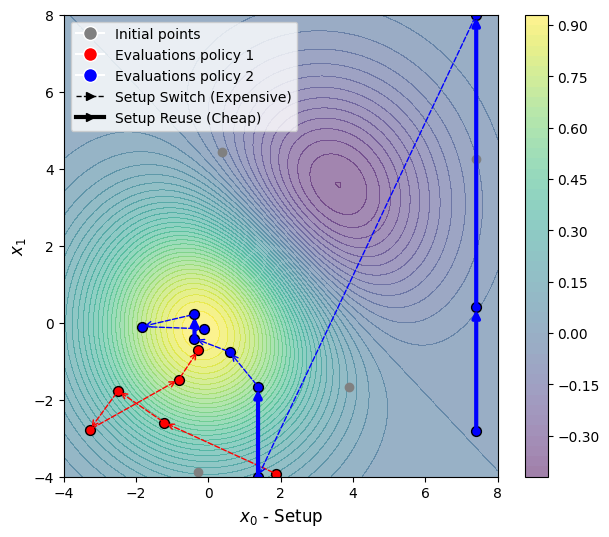

In [207]:
plot_seed(22, title="")

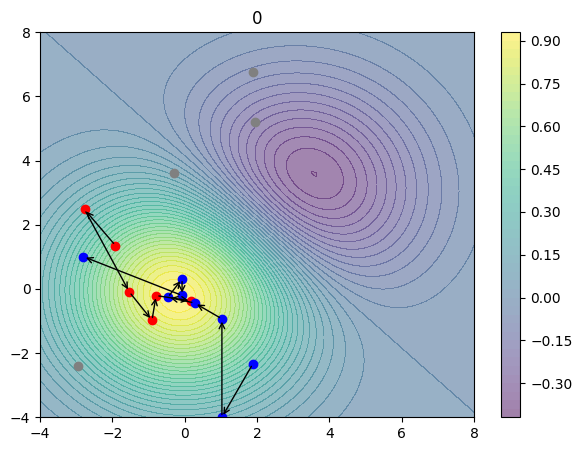

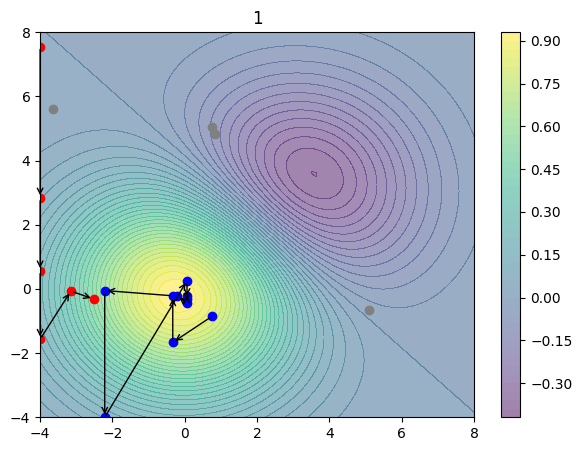

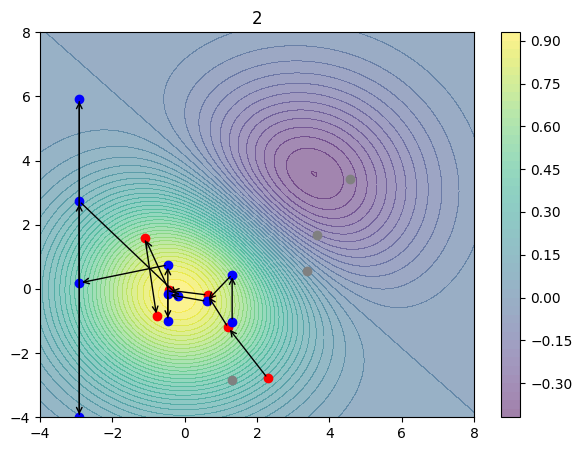

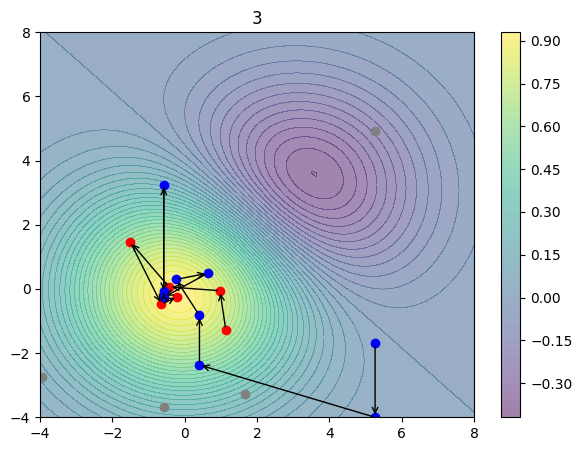

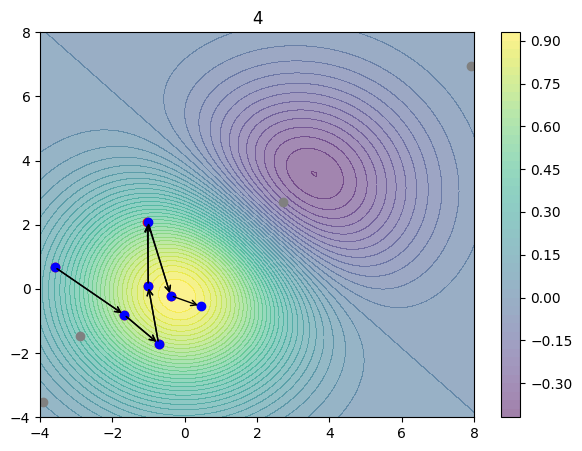

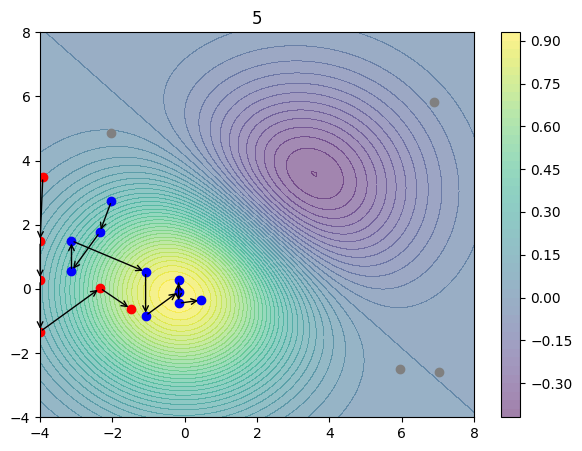

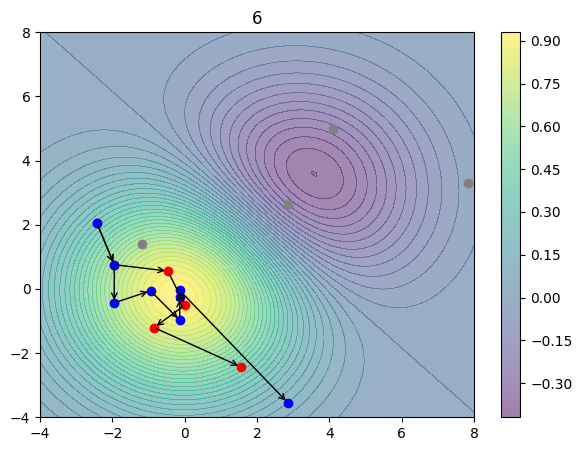

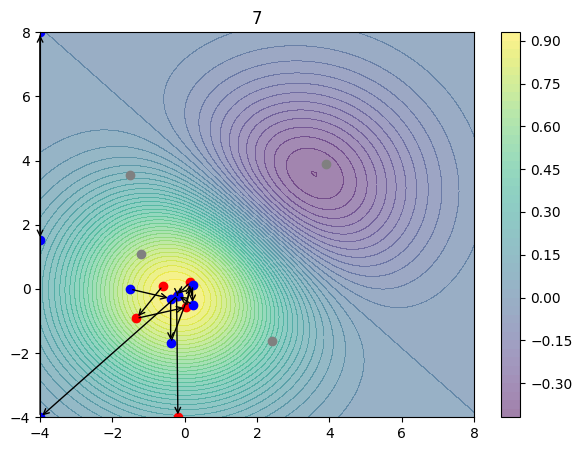

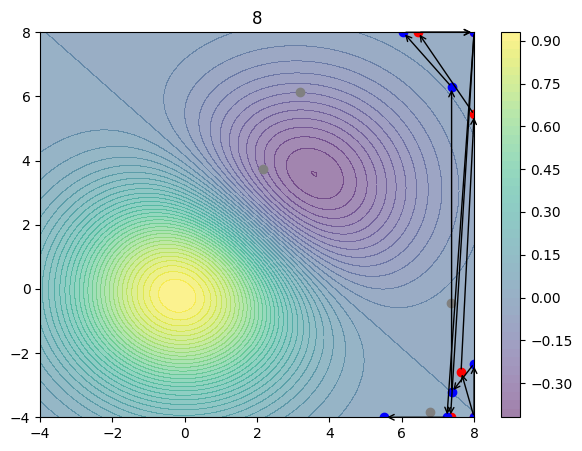

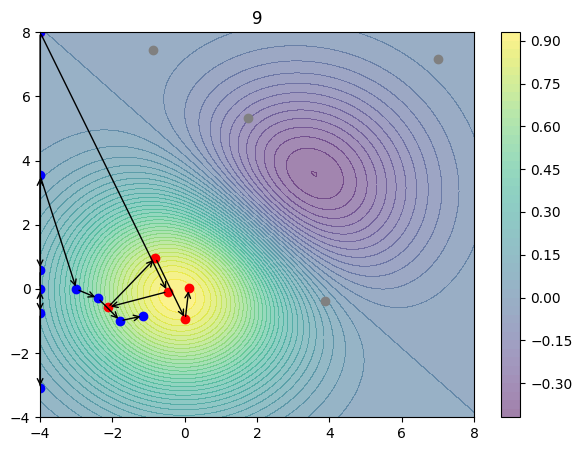

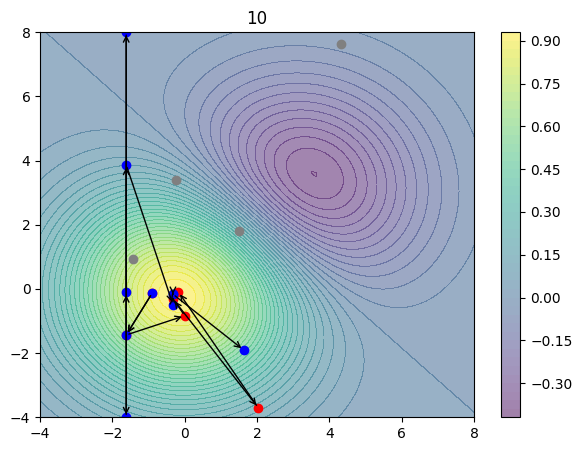

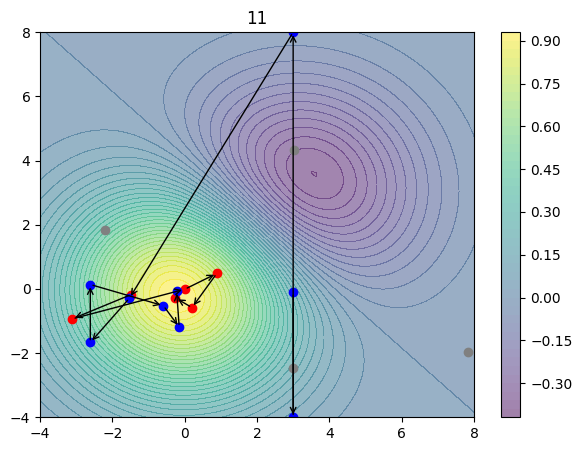

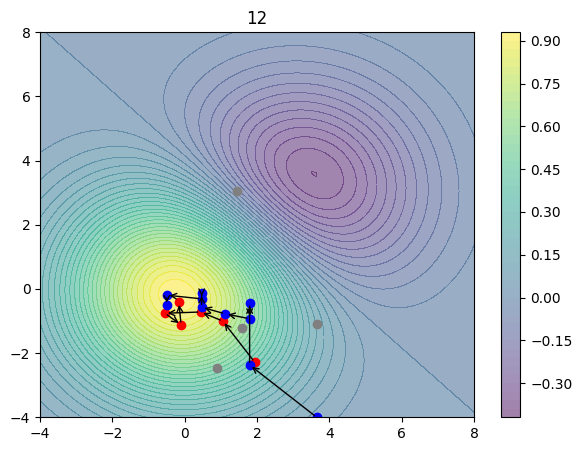

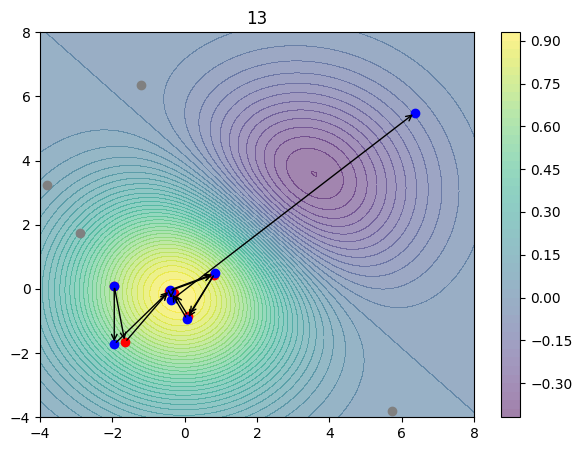

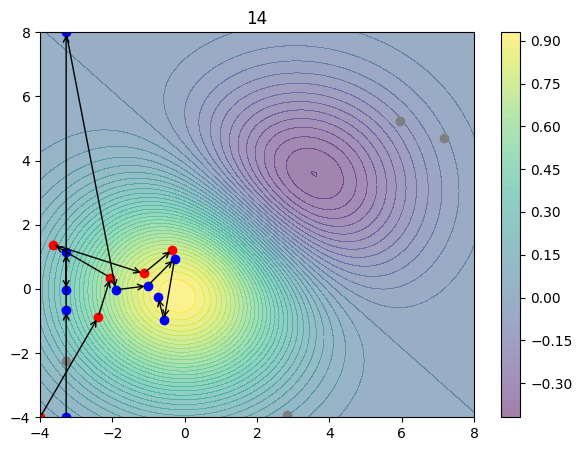

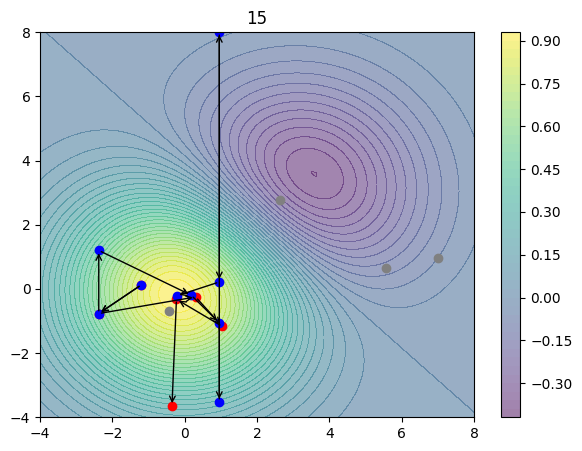

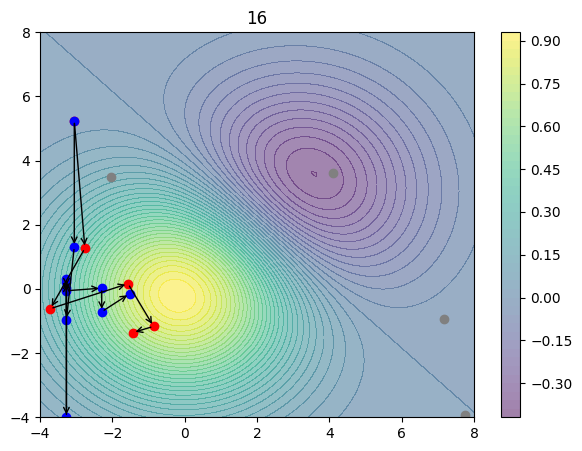

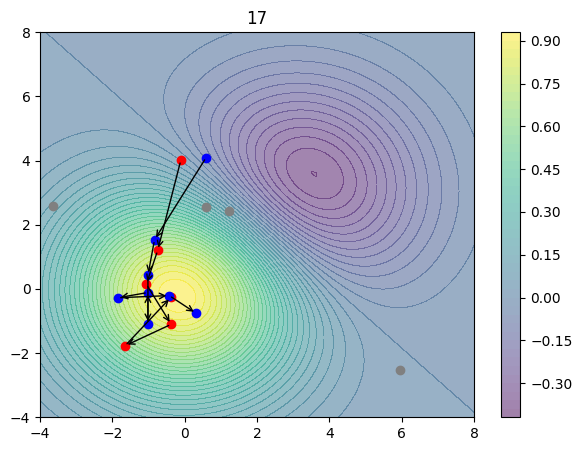

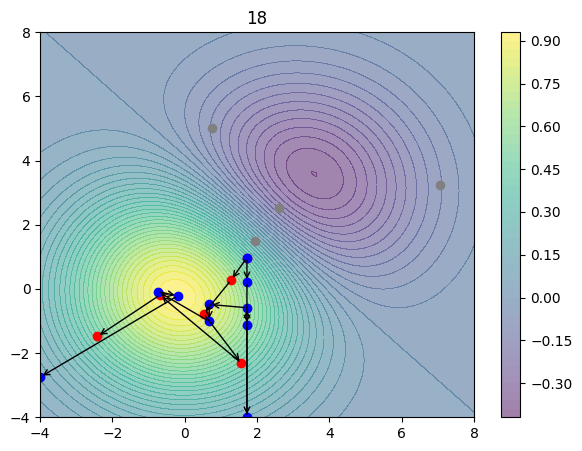

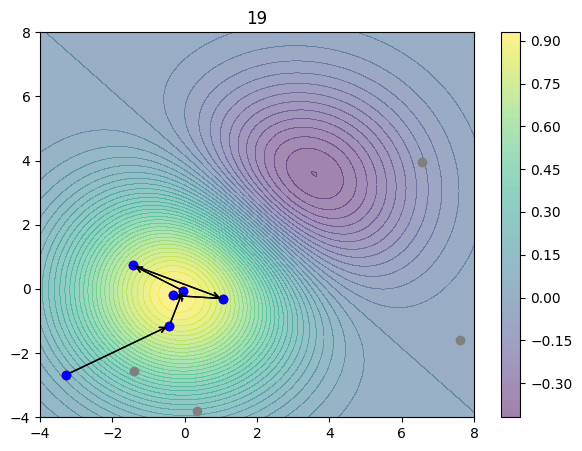

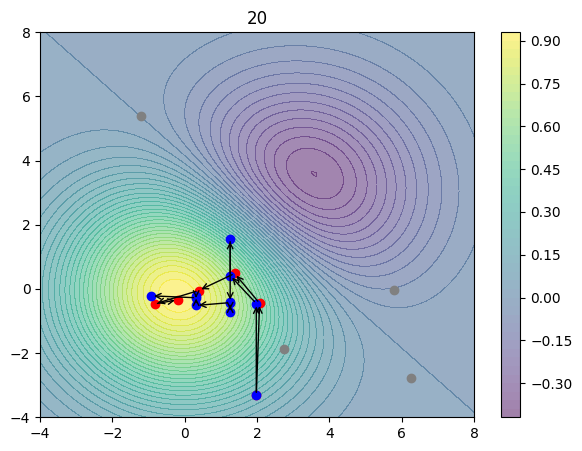

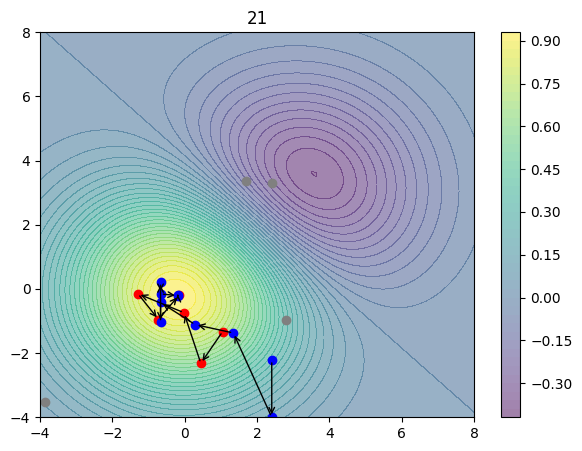

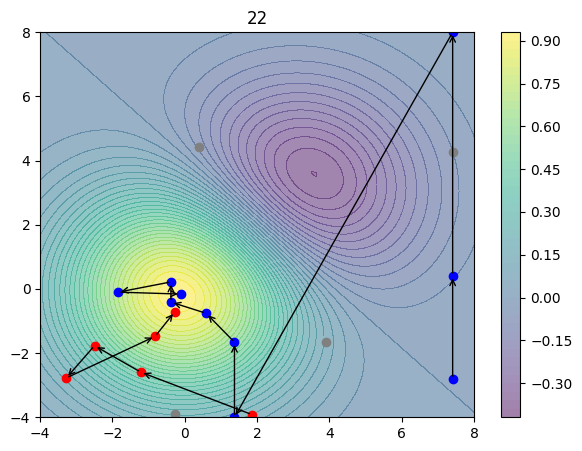

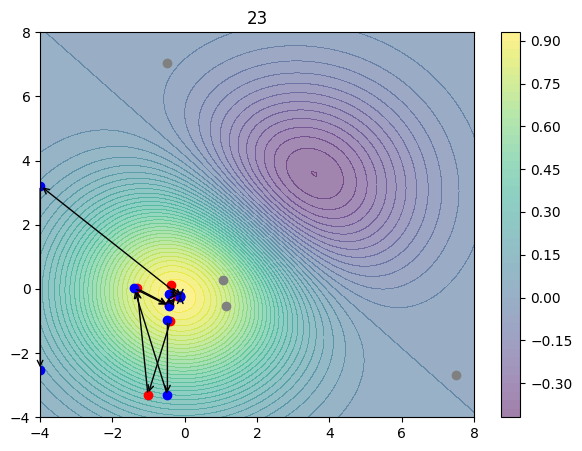

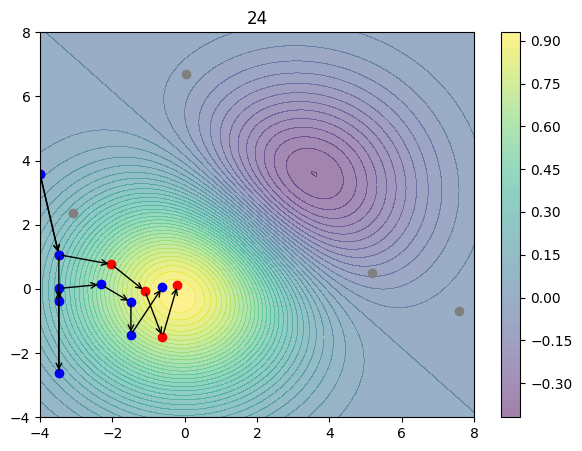

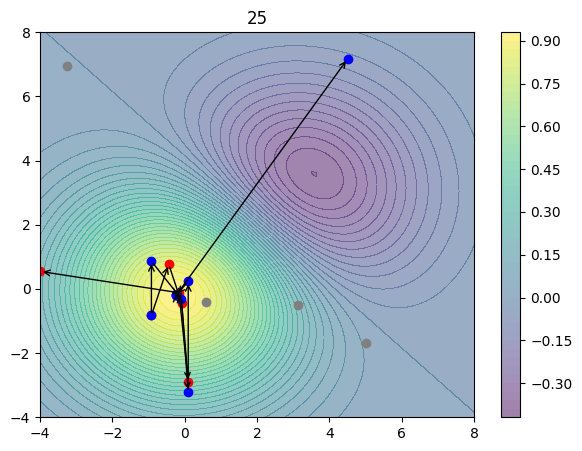

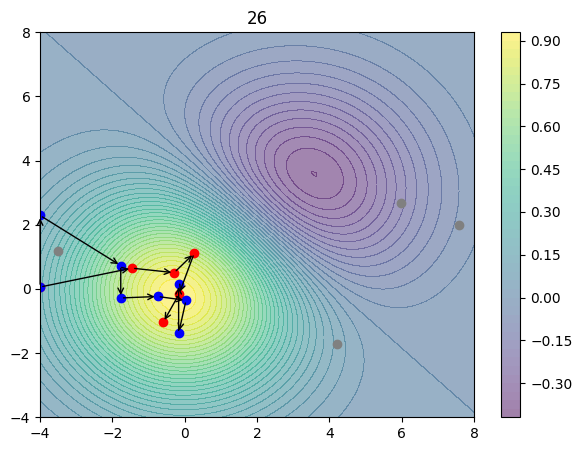

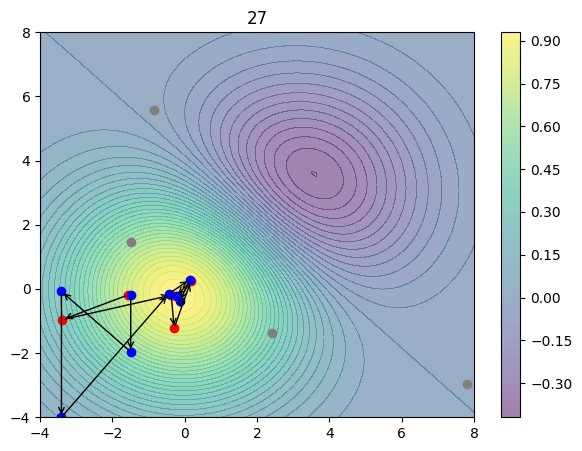

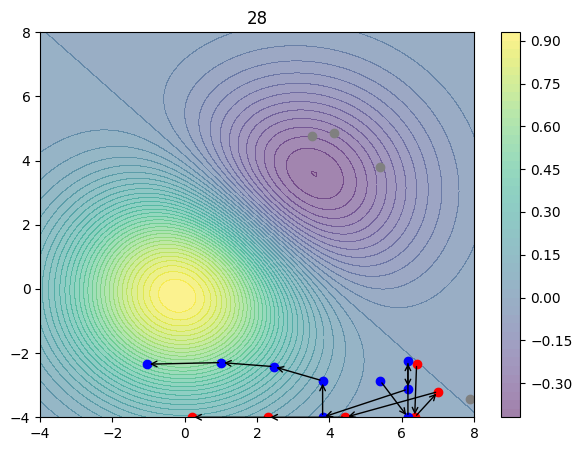

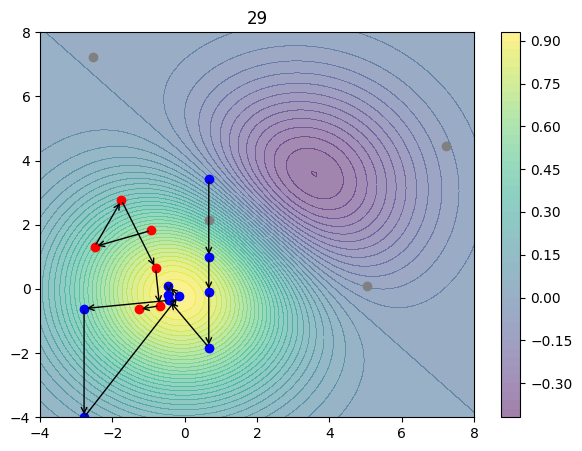

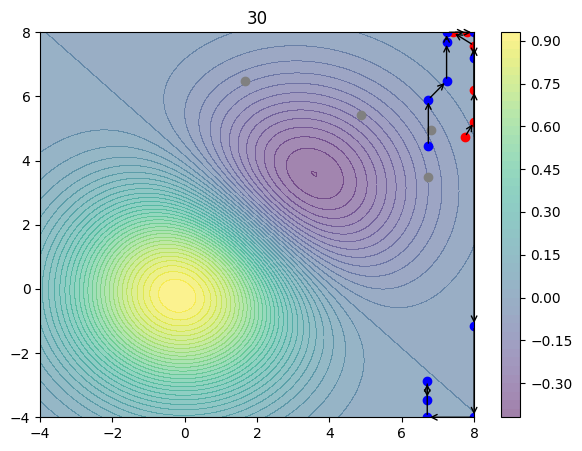

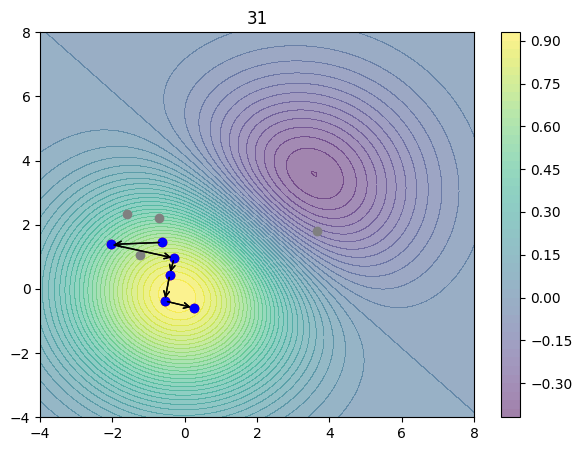

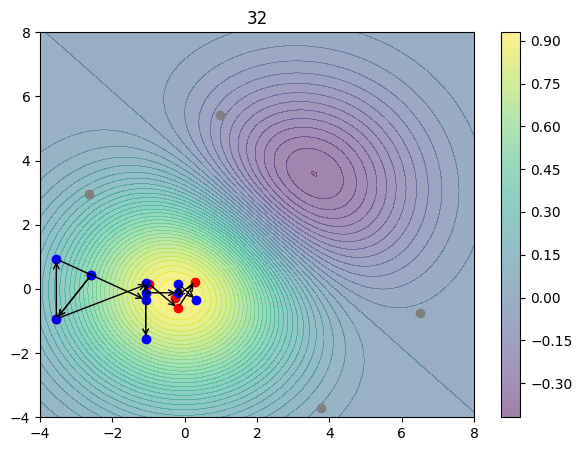

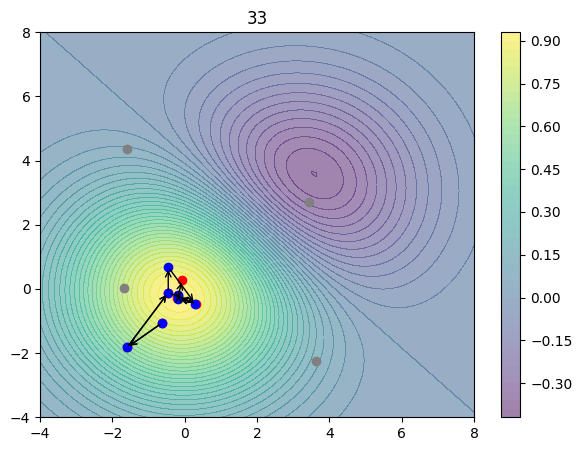

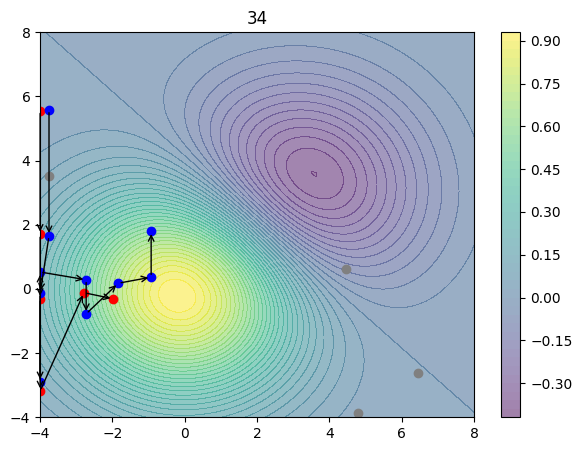

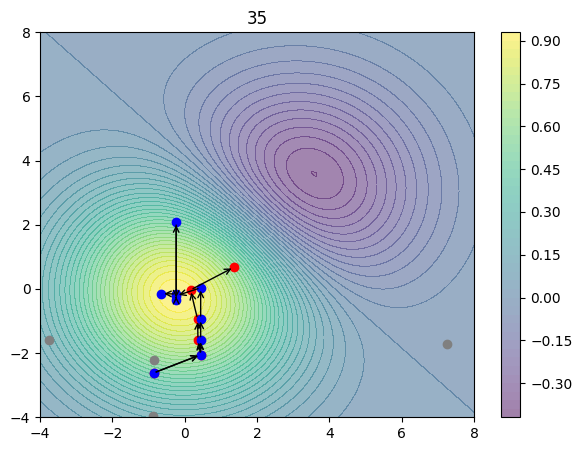

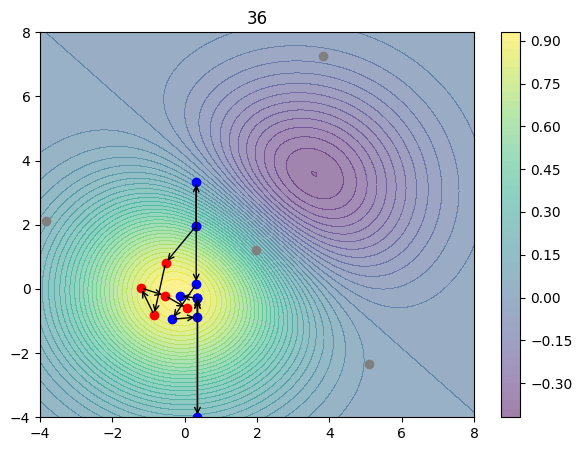

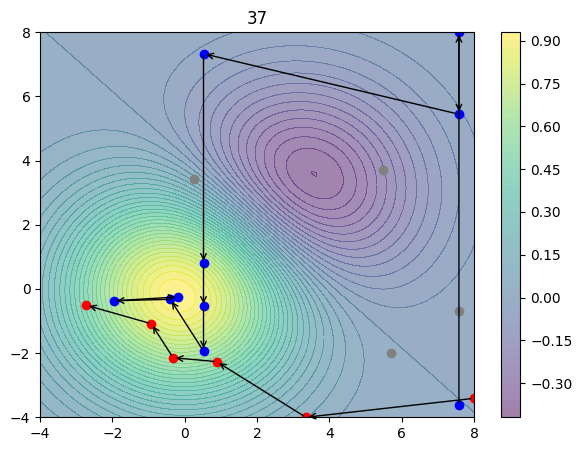

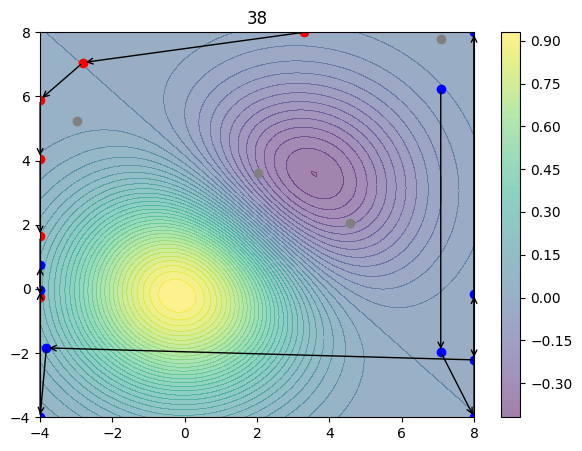

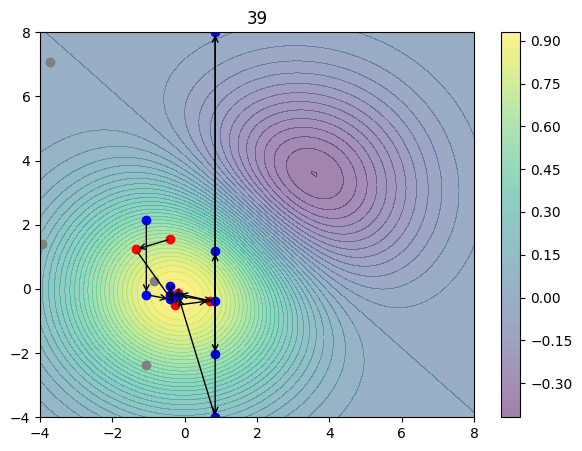

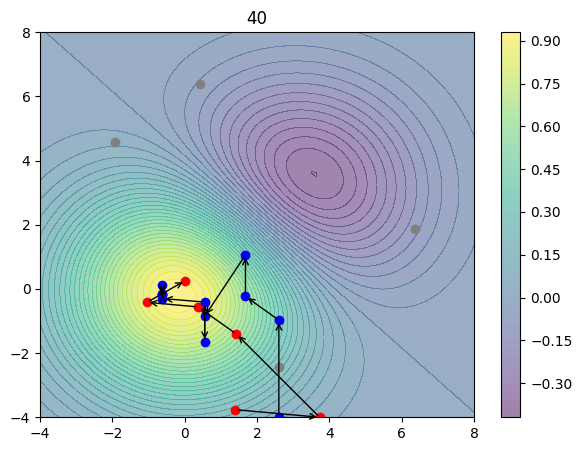

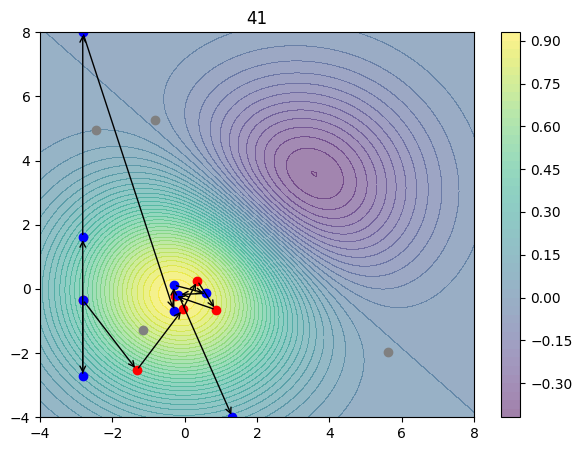

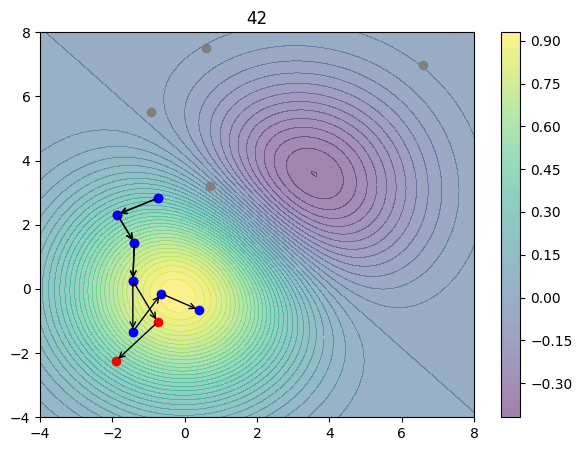

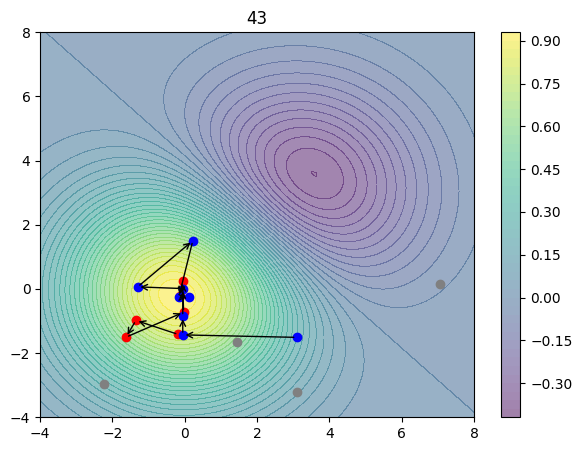

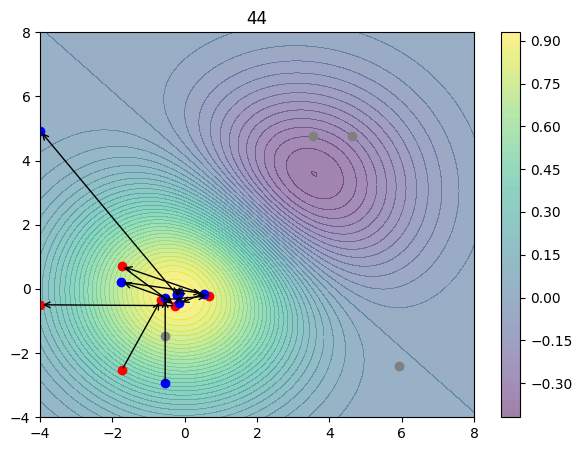

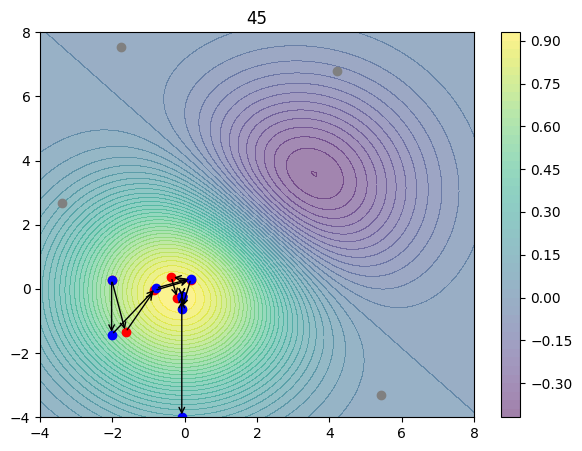

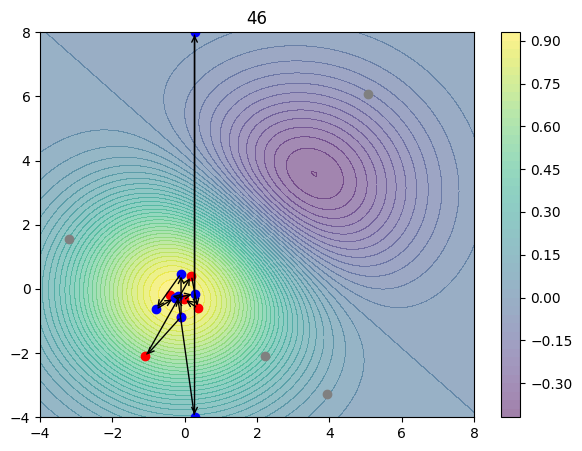

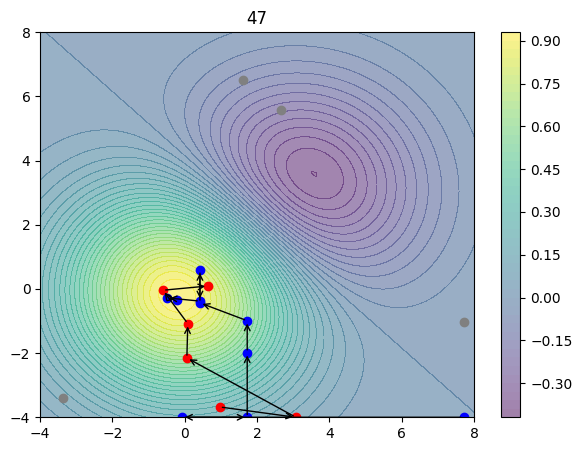

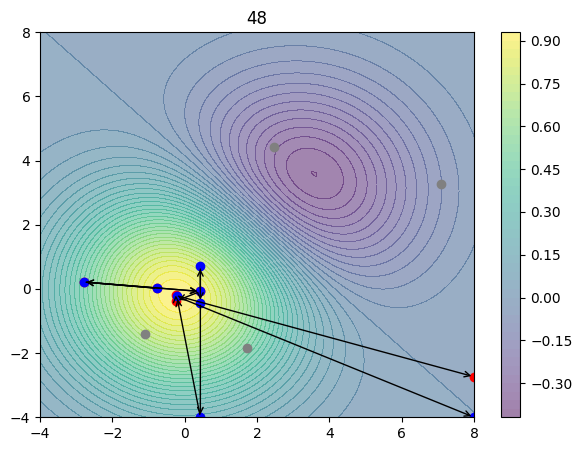

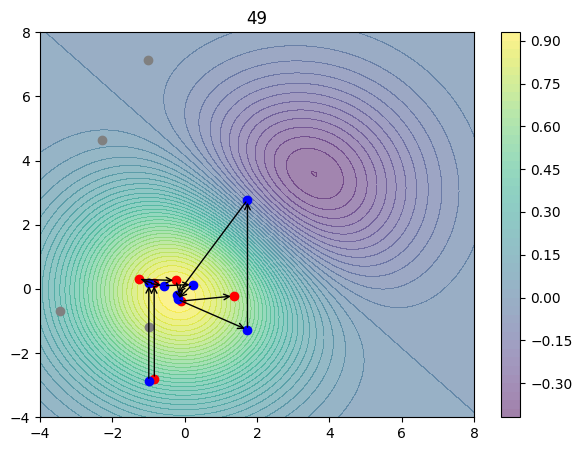

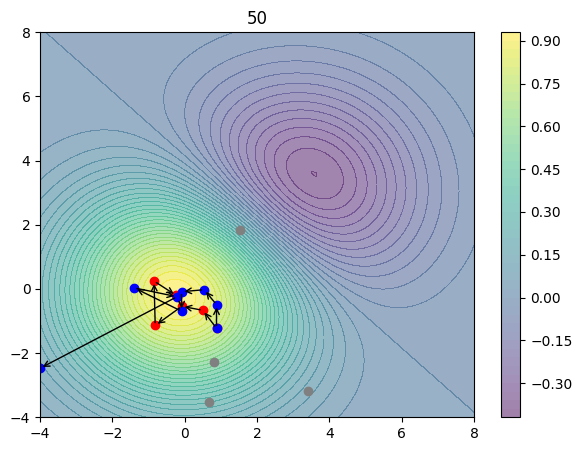

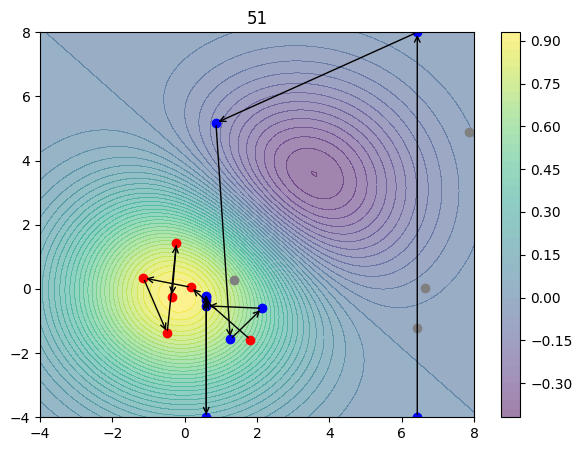

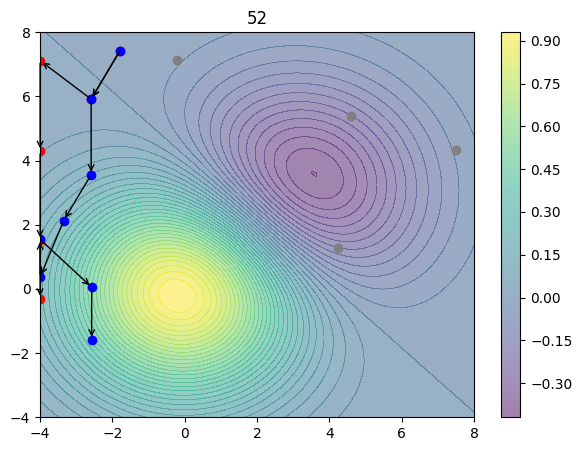

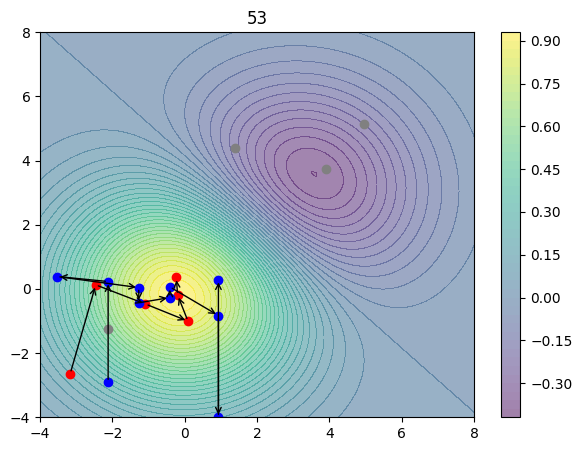

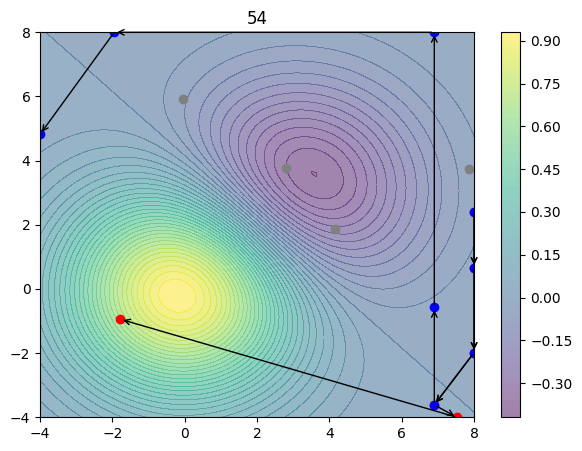

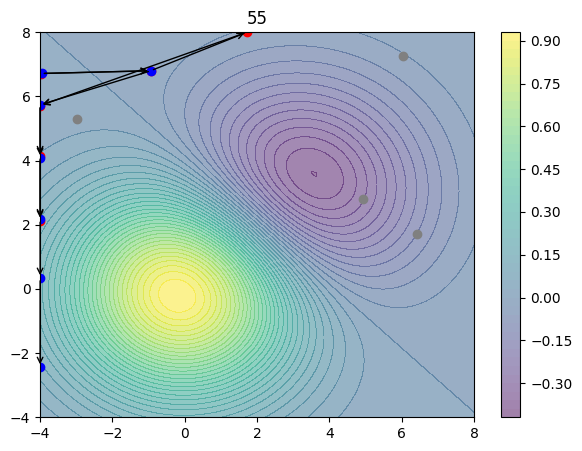

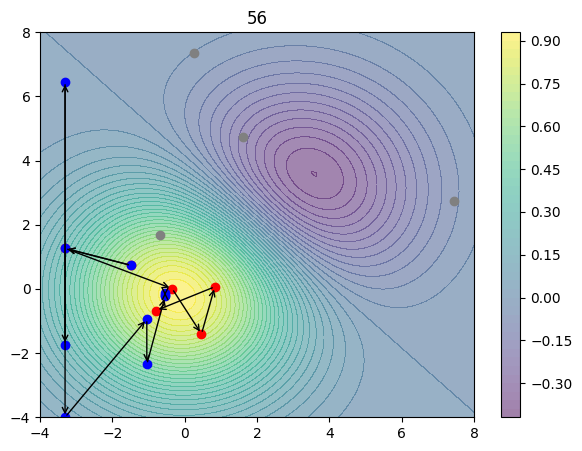

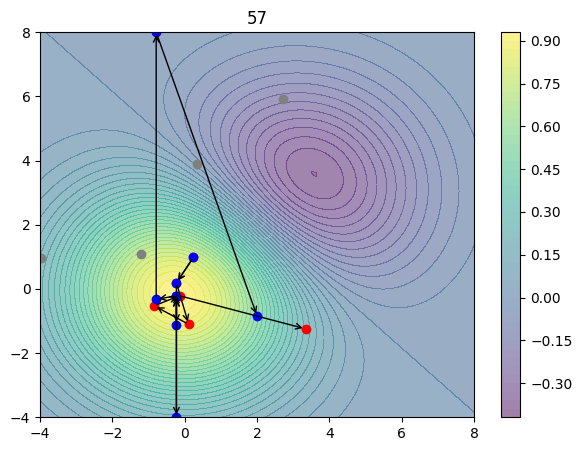

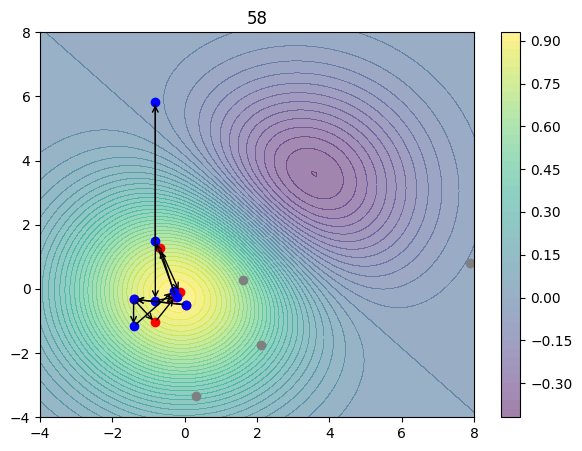

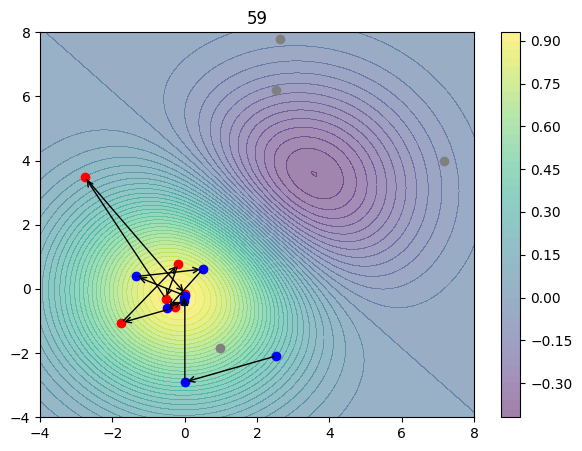

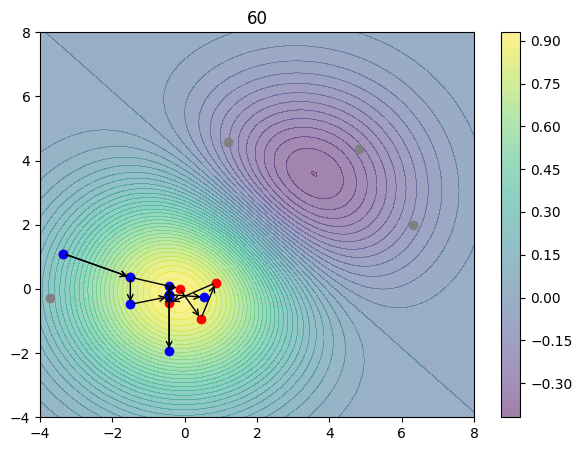

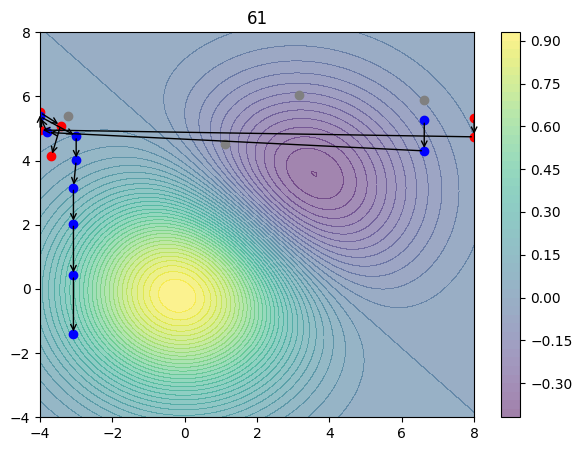

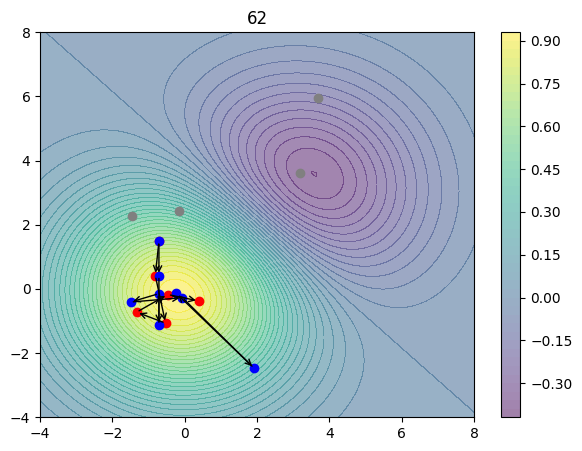

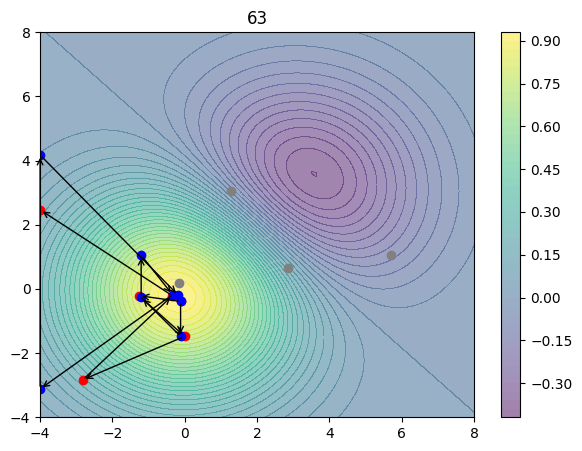

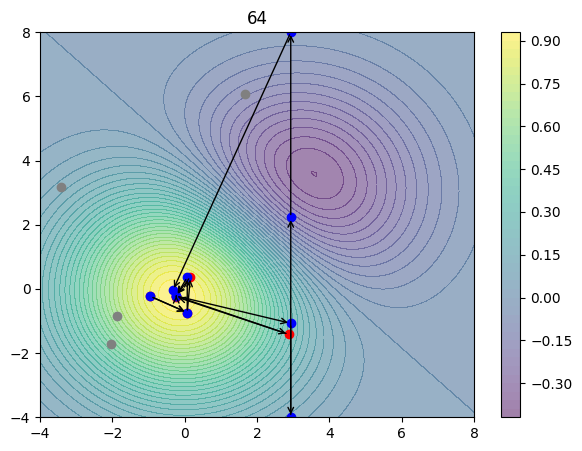

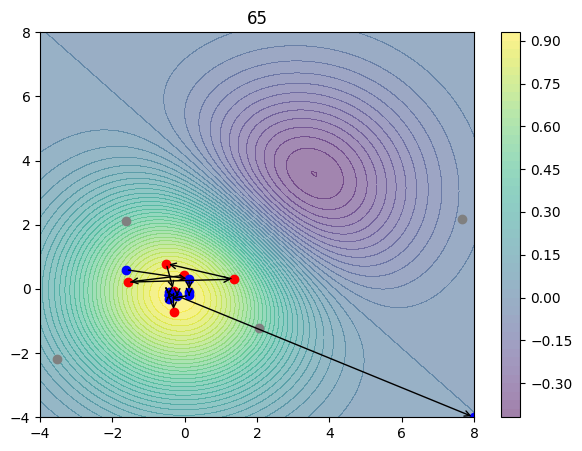

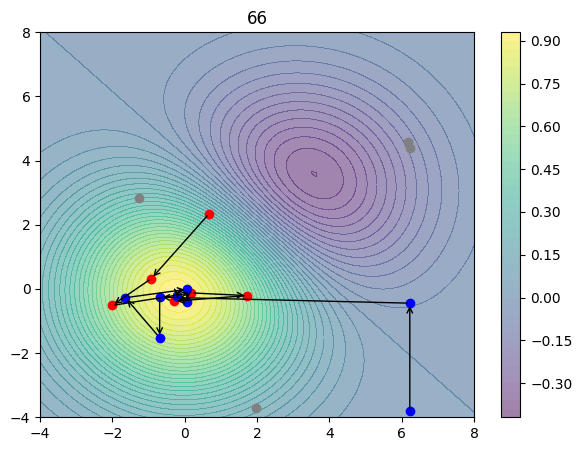

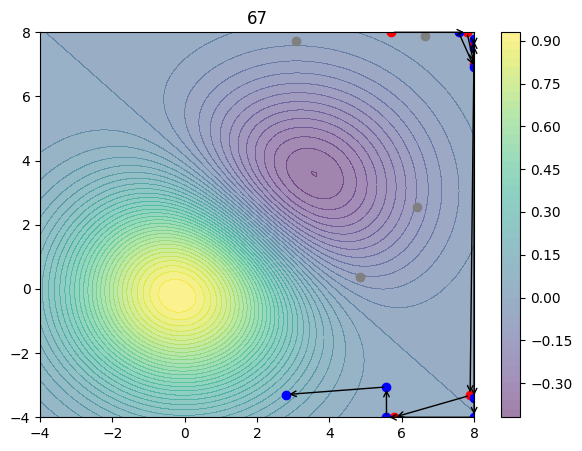

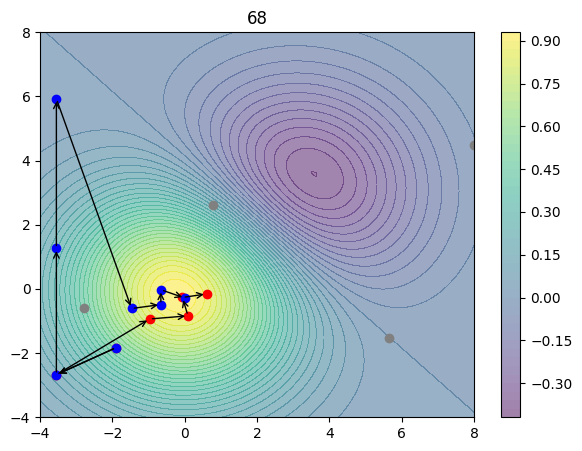

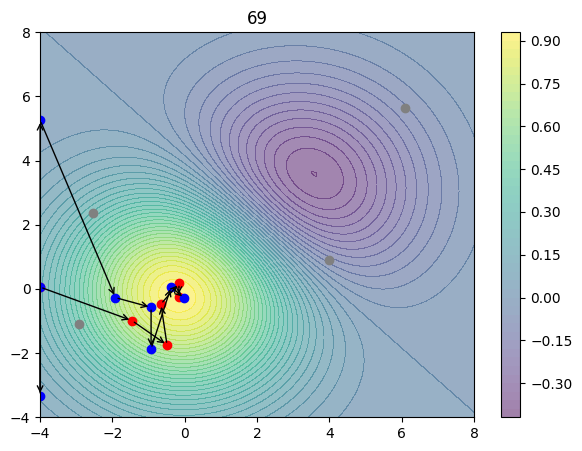

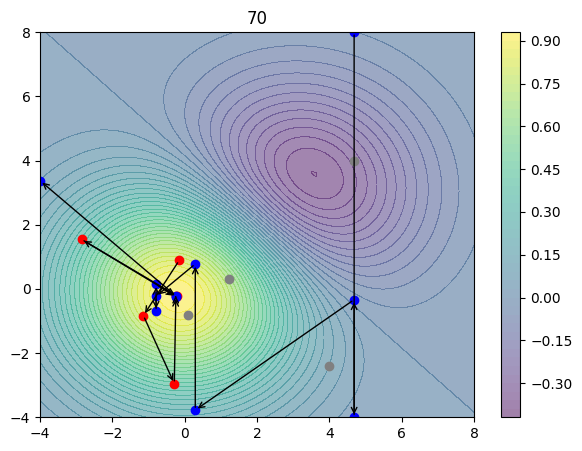

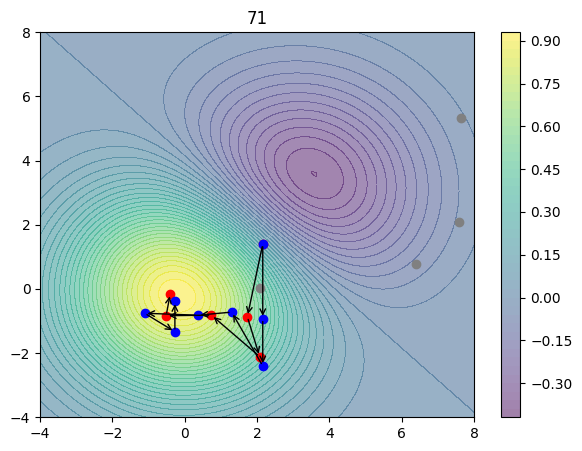

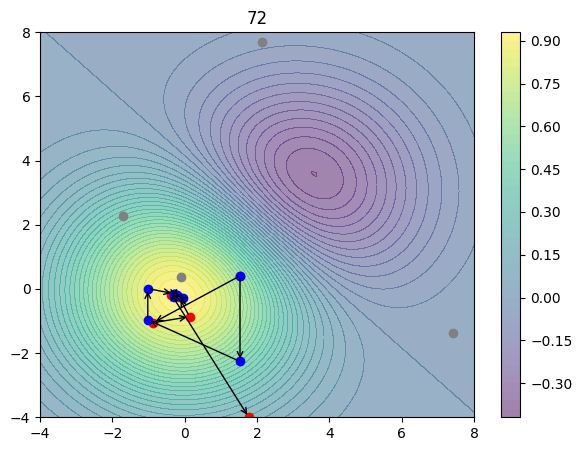

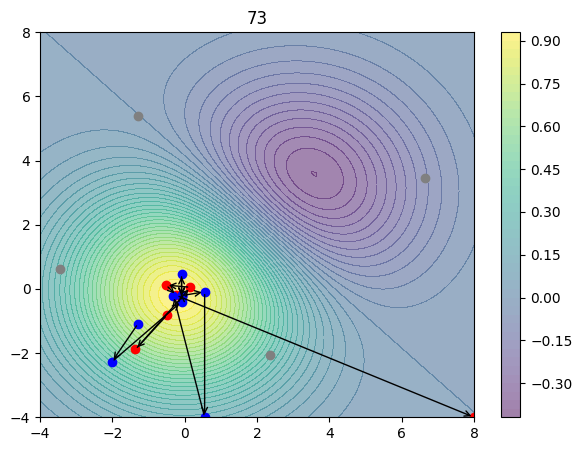

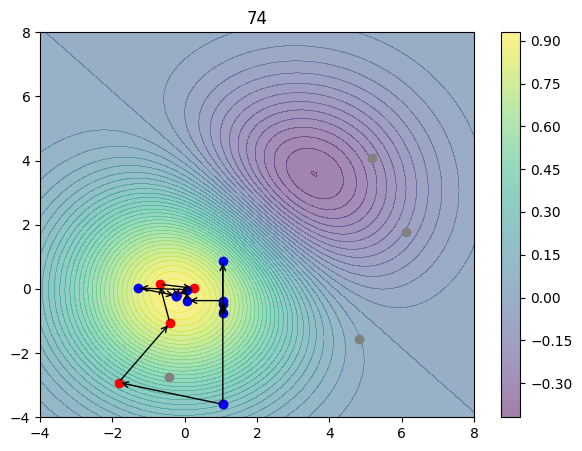

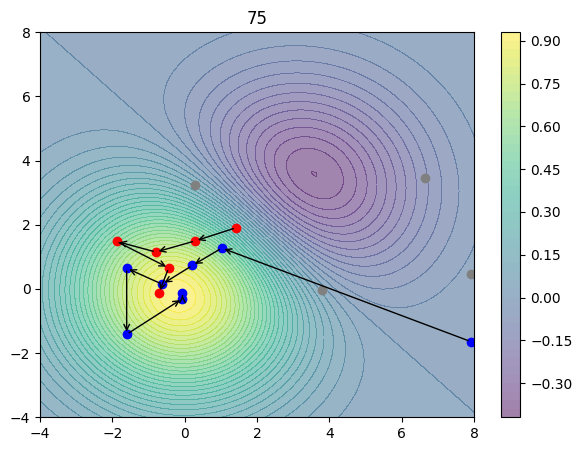

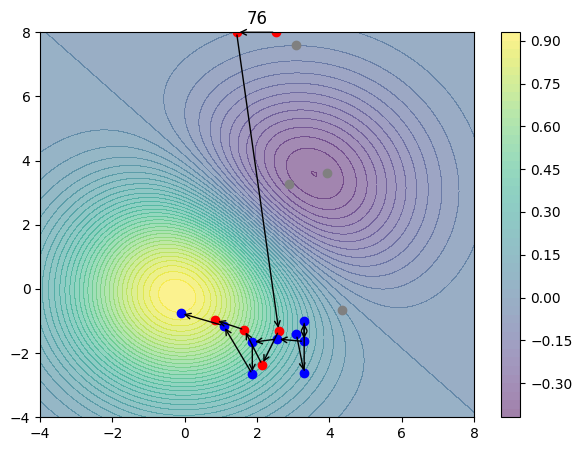

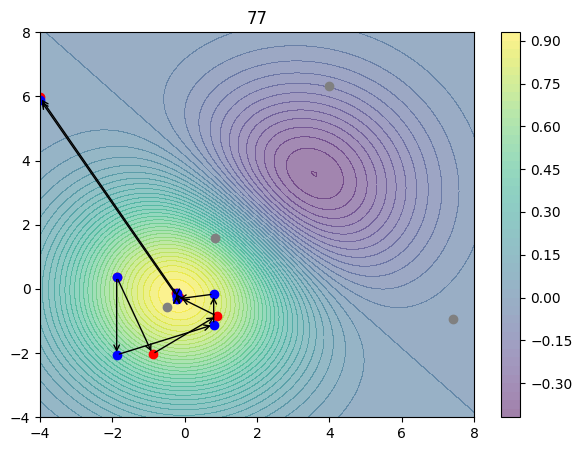

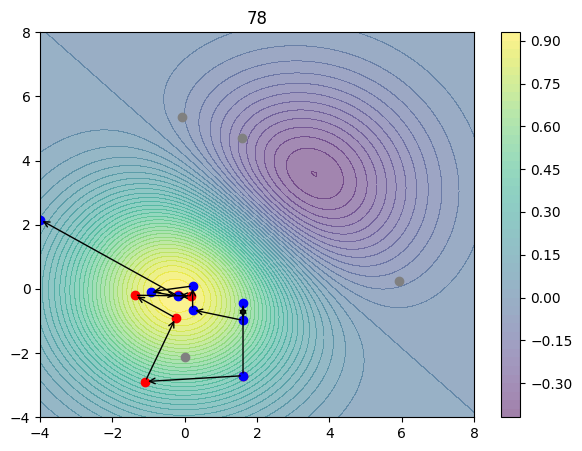

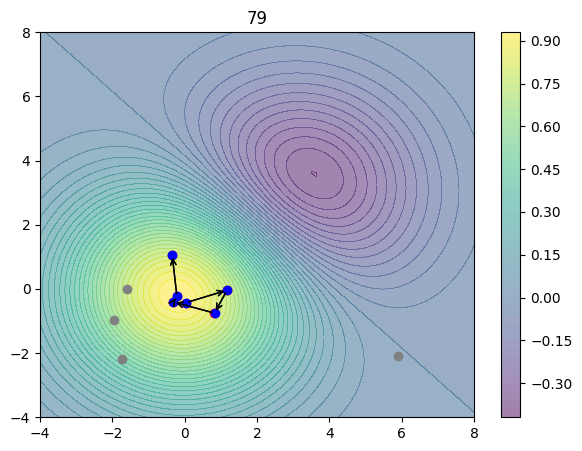

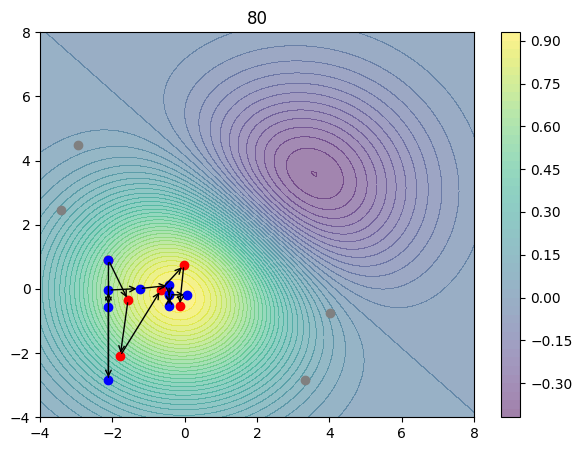

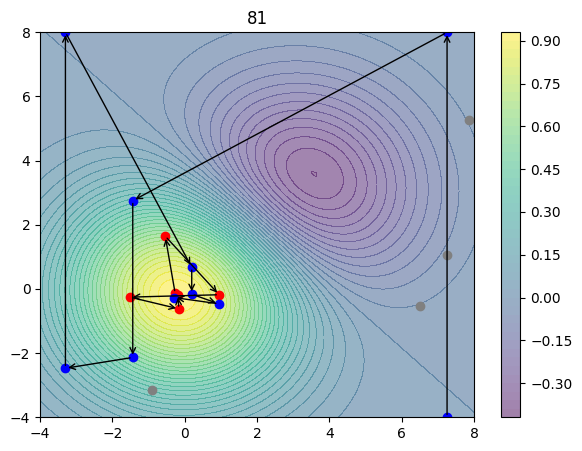

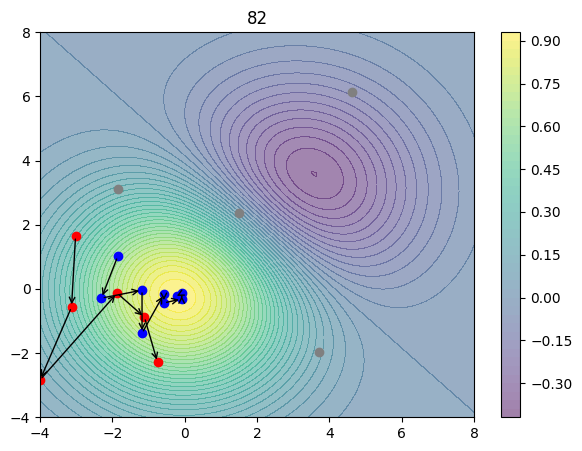

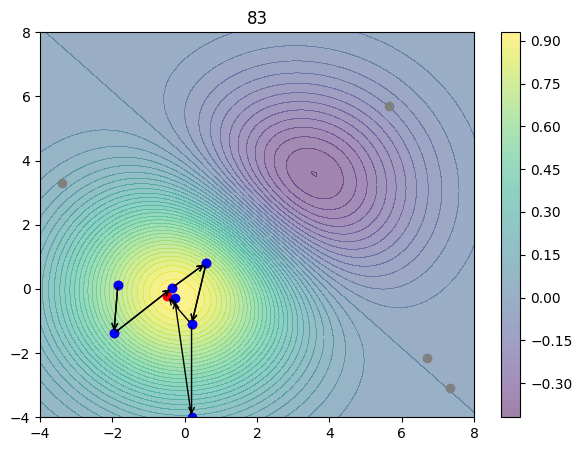

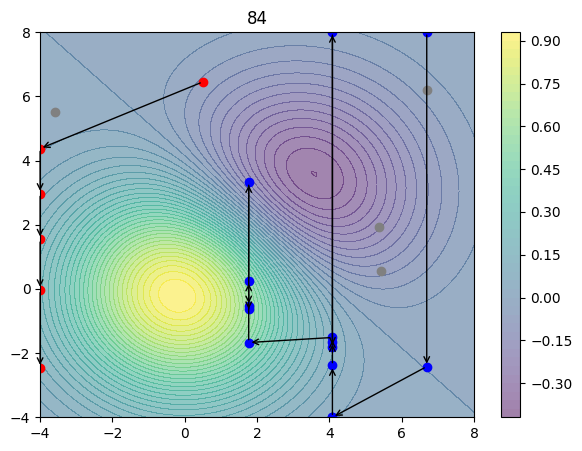

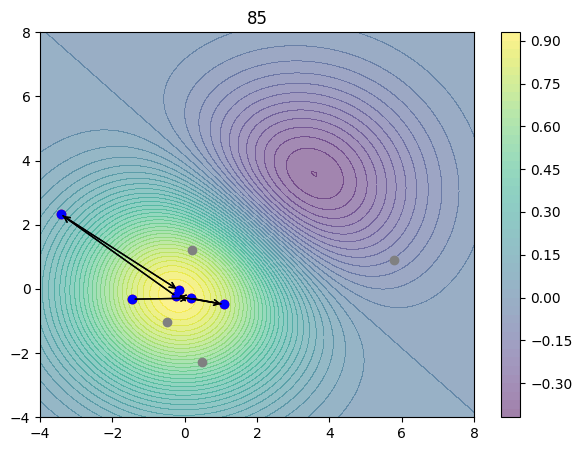

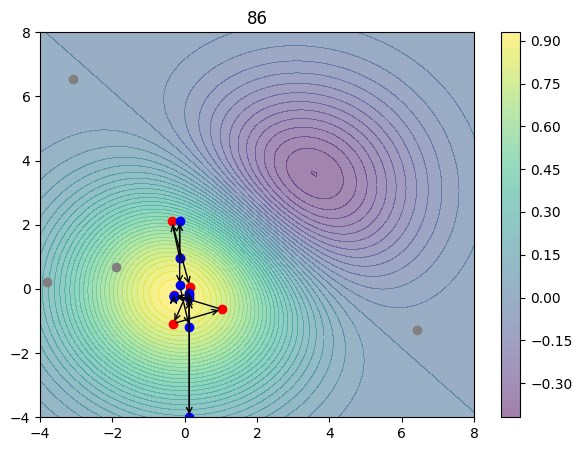

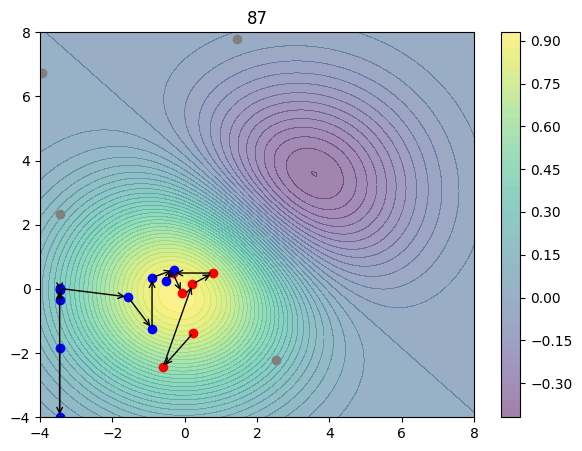

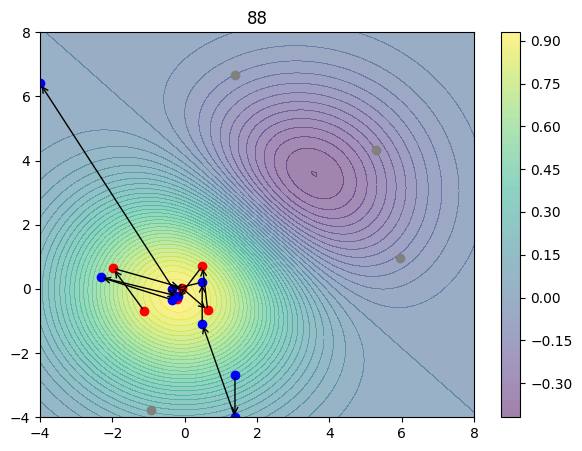

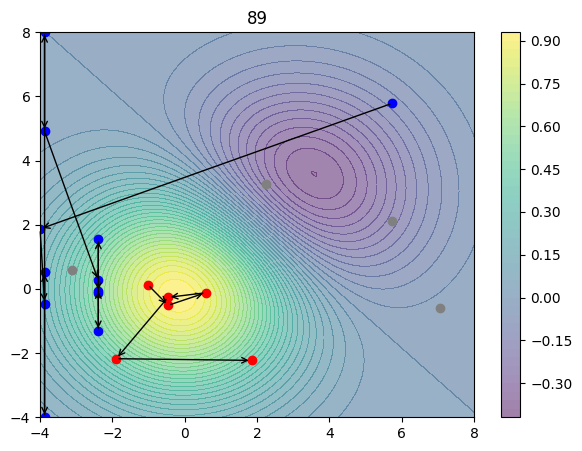

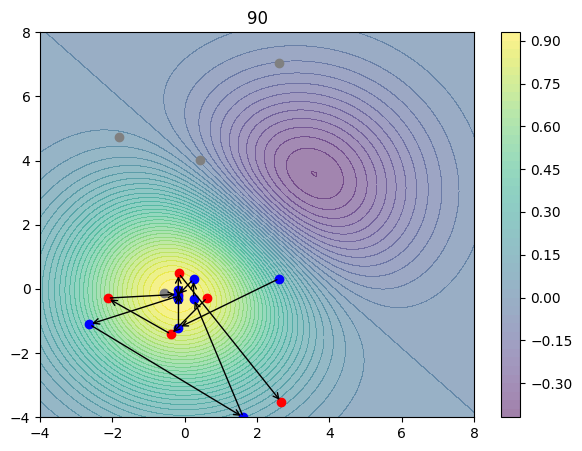

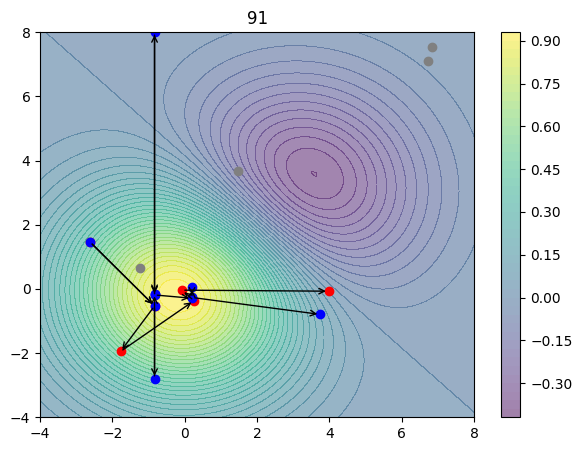

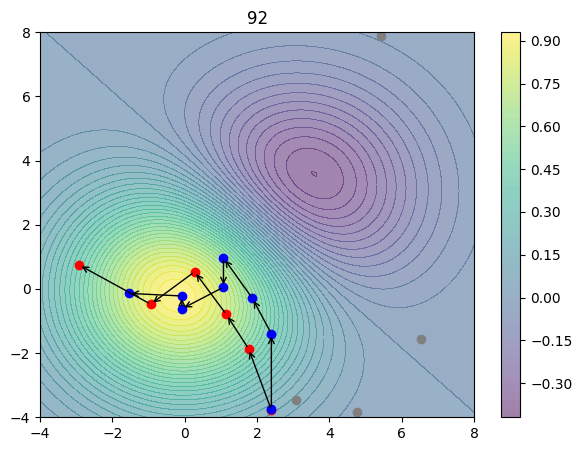

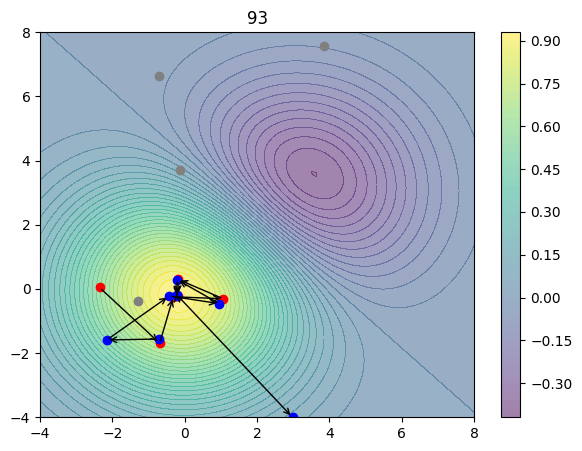

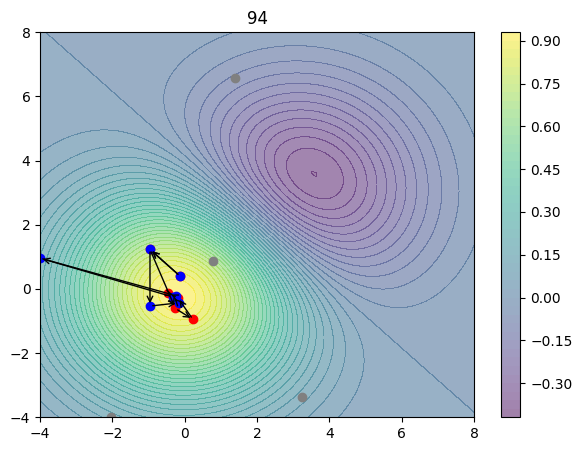

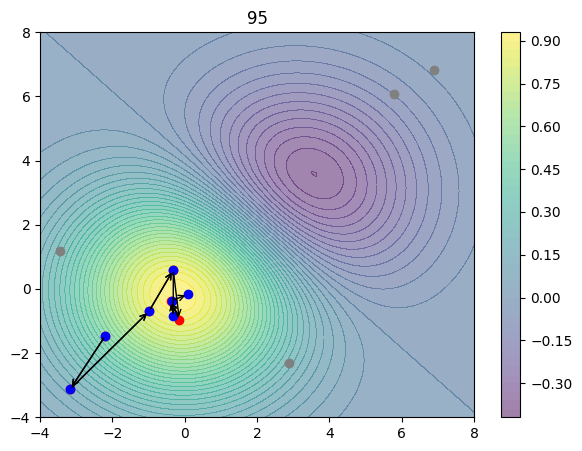

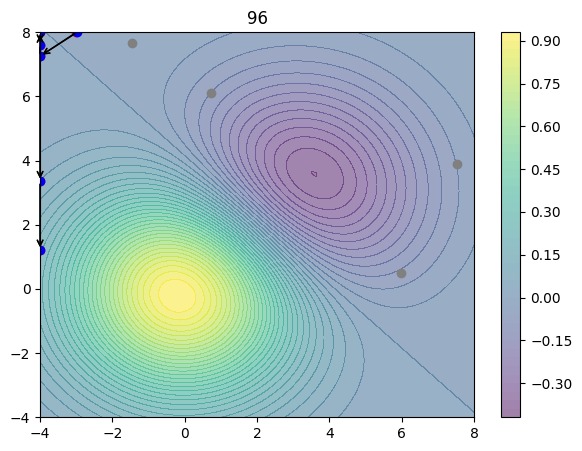

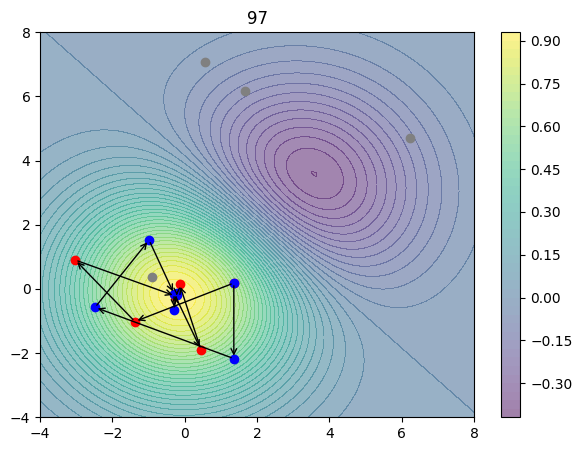

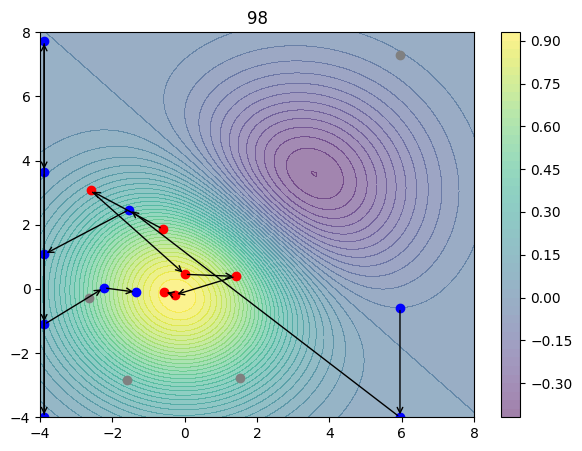

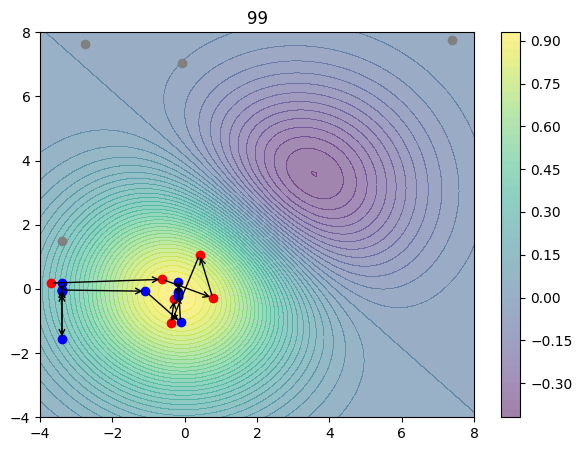

In [126]:
for i in range(100):
    plot_seed(i)